In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy
from torchvision.datasets import CIFAR10
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image

In [2]:
train_dataset = CIFAR10('../data/CIFAR10/', download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10('../data/CIFAR10/', download=True, train=False, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
test_data, test_labels = next(iter(test_loader))

In [4]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        quantiles = 3
        self.fe = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.MaxPool2d(2),
        )
        self.quantile_preds = nn.ModuleList([nn.Linear(256, 10) for _ in range(quantiles)])
        
    def forward(self, x):
        z = self.fe(x).view(x.shape[0], -1)
        return [self.quantile_preds[i](z) for i in range(len(self.quantile_preds))]

In [5]:
model = NN()

In [6]:
# optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
best_val_loss = np.inf
patience = 0
temperatures = [-1, 0, 1]

for epoch_idx in range(10000):
    
    for data, target in tqdm(train_loader):
        outputs = model(data)
        losses = [torch.nn.functional.cross_entropy(
            outputs[i], 
            target, 
        ) for i in range(len(outputs))]

        losses = sum(losses)
        
        kl_losses = [temperatures[i] * torch.nn.functional.kl_div(torch.full_like(outputs[i], 1 / outputs[i].shape[1]), outputs[i])
                     for i in range(len(outputs))]
        
        loss = losses + sum(kl_losses)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch_idx % 1 == 0:
        outputs_val = model(test_data)
        losses_val = [temperatures[i] * torch.nn.functional.cross_entropy(
            outputs_val[i], 
            test_labels
        ) for i in range(len(outputs))]
    
        loss_val = sum(losses_val) 
        
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
            torch.save(model.state_dict(), 'tmp.pth')
        else:
            patience += 1
            
            if patience == 8:
                model.load_state_dict(torch.load('tmp.pth'))
                break
    

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/david/miniconda3/envs/py37/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/david/miniconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/david/miniconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/david/miniconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/david/miniconda3/envs/py37/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/david/miniconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    out_conf, out, out_diff = model(test_data)

In [11]:
out_conf, out, out_diff = torch.softmax(out_conf, dim=-1).numpy(), torch.softmax(out, dim=-1).numpy(), torch.softmax(out_diff, dim=-1).numpy()

In [12]:
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

In [13]:
entropy(out_conf.T).mean(), entropy(out.T).mean(), entropy(out_diff.T).mean()

(0.47014746, 0.8805854, 1.472975)

In [44]:
uncs = out_conf - out_diff

In [25]:
preds = out.argmax(-1)

In [26]:
M = uncs[range(len(uncs)), preds]


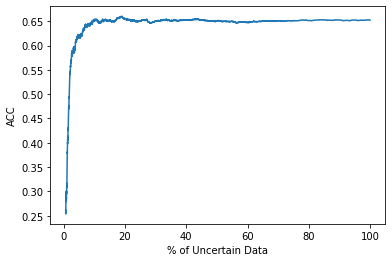

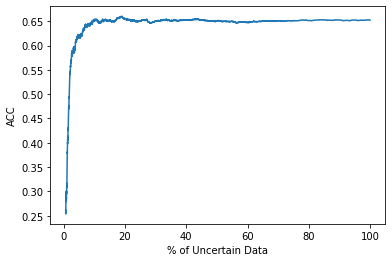

In [27]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, M, 'ACC', performance_fn=accuracy_score)

In [34]:
uncs = (entropy(out_diff.T) - entropy(out_conf.T))

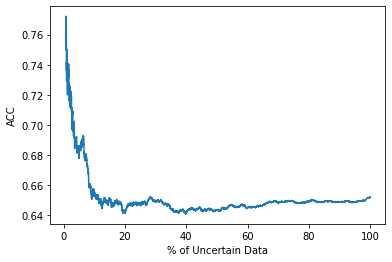

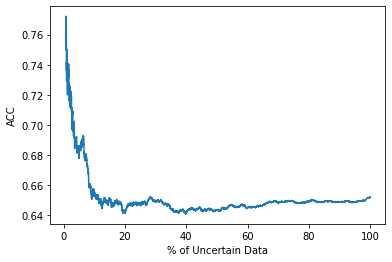

In [45]:

make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'ACC', performance_fn=accuracy_score)

In [37]:
y * (1 - 6))*D_KL(U| p(y|x)) 

array([3, 8, 8, ..., 5, 1, 7])

In [42]:
cross_entropy(test_labels, out, n_labels=10)

array([1.02316689, 1.15887678, 0.41626149, ..., 0.07128917, 1.28670824,
       0.13041002])

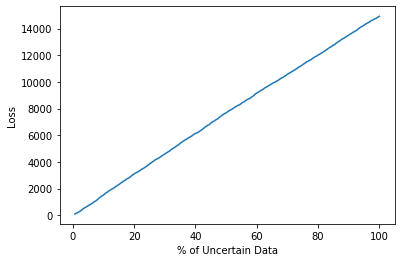

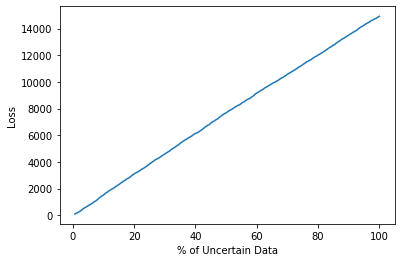

In [46]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'Loss', performance_fn_args={'reduction': 'sum'})

In [ ]:
def softmax(outputs, t=1):
    return (torch.exp(t * outputs) / (torch.sum(torch.exp(t * outputs), dim=-1, keepdim=True)))

In [ ]:
softmax(outputs)

In [ ]:
softmax(outputs, t=0.5)

In [ ]:
# preds = torch.softmax(outputs, dim=-1)

In [ ]:
y = torch.randint(0, 10, (len(outputs),))

In [ ]:
torch.nn.functional.cross_entropy(preds, y)

In [ ]:
softmax(outputs * 2).max()

In [ ]:
torch.nn.functional.nll_loss(torch.log(softmax(outputs * 2, t=2)), y)

In [ ]:
def log_softmax(outputs, dim=-1, t=1):
    return outputs * t - torch.log(torch.sum(torch.exp(t * outputs), dim=dim, keepdim=True))

In [ ]:
torch.nn.functional.nll_loss(log_softmax(outputs), y)

In [ ]:
torch.nn.functional.nll_loss(log_softmax(outputs, t=2), y)

In [ ]:
torch.nn.functional.nll_loss(log_softmax(outputs / 2, t=2), y)

In [ ]:
torch.log(torch.softmax(outputs, dim=-1))

In [ ]:
torch.nn.functional.nll_loss(torch.softmax(outputs, dim=1), y)

In [ ]:
log_softmax(outputs)

In [ ]:
torch.nn.functional.nll_loss(log_softmax(outputs), y)

In [ ]:
torch.nn.functional.cross_entropy(outputs, y)

In [ ]:
softmax(outputs)